In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#| code-fold: false
# IMPORTING LIBRARIES
# --------------------

# AstroML & Astropy
from astroML.datasets import fetch_LINEAR_sample
from astropy.timeseries import LombScargle
from astroML.datasets import fetch_LINEAR_sample
from astroML.datasets import fetch_LINEAR_geneva
from astropy.timeseries import TimeSeries
from astropy.table import Table
from astroML.time_series import MultiTermFit
from astropy.coordinates import SkyCoord
import astropy.units as u


# ZTF
from ztfquery import lightcurve

# Basic libraries
import random
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import interact, interactive, fixed, interact_manual

# DataFrame analysis
import pandas as pd
import dask.dataframe as dd 

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm
from scipy.signal import find_peaks
from array import array

In [3]:
#| code-fold: false
# CONFIG
sns.set_theme() # setting the theme for plotting
np.random.seed(42)

colors = ['#1A090D', '#D8C99B', '#D8973C', '#BD632F', '#273E47']
cmap = mcolors.ListedColormap(colors)

font = FontProperties()
font.set_family('avenir')
font.set_name('Avenir')
font.set_style('normal')
font.set_size('xx-large')

%matplotlib inline  

In [4]:
#| code-fold: false
# Importing custom libraries
# ----------------------------
sys.path.insert(0,'../src/')
from config import*
#from descriptive_stats import *
#from plots import *

from selection import *
from blazhko_analysis import blazhko_determine, sort3arr, sort4arr, sigG, plotAll, makeLCplot_info

Loading the data!


In [5]:
#| code-fold: false
# DATA
dataLINEAR = fetch_LINEAR_sample(data_home='../inputs') # fetching the data from astroML data library

In [6]:
end = 'FINAL_FINAL_FULL'

In [7]:
#| code-fold: false
# DATA from previous notebook
lc_analysis = pd.read_csv('../outputs/LC_ANALYSIS_FINALFINAL_FINAL_FULL.csv')

lc_analysis['MainPeakL'] = pd.to_numeric(lc_analysis['MainPeakL'], errors='coerce').fillna(0)
lc_analysis['BlazhkoPeakL'] = pd.to_numeric(lc_analysis['BlazhkoPeakL'], errors='coerce').fillna(0)
lc_analysis['BlazhkoPeriodL'] = pd.to_numeric(lc_analysis['BlazhkoPeriodL'], errors='coerce').fillna(0)
lc_analysis['BpowerRatioL'] = pd.to_numeric(lc_analysis['BpowerRatioL'], errors='coerce').fillna(0)
lc_analysis['BsignificanceL'] = pd.to_numeric(lc_analysis['BsignificanceL'], errors='coerce').fillna(0)
lc_analysis['MainPeakZ'] = pd.to_numeric(lc_analysis['MainPeakZ'], errors='coerce').fillna(0)
lc_analysis['BlazhkoPeakZ'] = pd.to_numeric(lc_analysis['BlazhkoPeakZ'], errors='coerce').fillna(0)
lc_analysis['BlazhkoPeriodZ'] = pd.to_numeric(lc_analysis['BlazhkoPeriodZ'], errors='coerce').fillna(0)
lc_analysis['BpowerRatioZ'] = pd.to_numeric(lc_analysis['BpowerRatioZ'], errors='coerce').fillna(0)
lc_analysis['BsignificanceZ'] = pd.to_numeric(lc_analysis['BsignificanceZ'], errors='coerce').fillna(0)

lc_analysis['Pratio'] = round(lc_analysis['Pratio'], 4)
lc_analysis['Plinear'] = round(lc_analysis['Plinear'], 6)
lc_analysis['Pztf'] = round(lc_analysis['Pztf'], 6)
lc_analysis['Lampl'] = round(lc_analysis['Lampl'], 2)
lc_analysis['Zampl'] = round(lc_analysis['Zampl'], 2)
lc_analysis['L_chi2dofR'] = round(lc_analysis['L_chi2dofR'], 1)
lc_analysis['Lmean_chi2dofR'] = round(lc_analysis['Lmean_chi2dofR'], 1)
lc_analysis['Zchi2dofR'] = round(lc_analysis['Zchi2dofR'], 1)
lc_analysis['Zmean_chi2dofR'] = round(lc_analysis['Zmean_chi2dofR'], 1)
lc_analysis['L_chi2dof'] = round(lc_analysis['L_chi2dof'], 1)
lc_analysis['Lmean_chi2dof'] = round(lc_analysis['Lmean_chi2dof'], 1)
lc_analysis['Zchi2dof'] = round(lc_analysis['Zchi2dof'], 1)
lc_analysis['Zmean_chi2dof'] = round(lc_analysis['Zmean_chi2dof'], 1)
lc_analysis['Ampl_diff'] = round(abs(lc_analysis['Lampl'] - lc_analysis['Zampl']), 2)
lc_analysis['dP'] = round(abs((lc_analysis['Plinear']-lc_analysis['Pztf'])/lc_analysis['Pmean']),5)
lc_analysis['MainPeakL'] = round(lc_analysis['MainPeakL'], 4)
lc_analysis['BlazhkoPeakL'] =round(lc_analysis['BlazhkoPeakL'], 4)
lc_analysis['BlazhkoPeriodL'] = round(lc_analysis['BlazhkoPeriodL'], 4)
lc_analysis['BpowerRatioL'] = round(lc_analysis['BpowerRatioL'], 4)
lc_analysis['BsignificanceL'] = round(lc_analysis['BsignificanceL'], 4)
lc_analysis['MainPeakZ'] = round(lc_analysis['MainPeakZ'], 4)
lc_analysis['BlazhkoPeakZ'] = round(lc_analysis['BlazhkoPeakZ'], 4)
lc_analysis['BlazhkoPeriodZ'] = round(lc_analysis['BlazhkoPeriodZ'], 4)
lc_analysis['BpowerRatioZ'] = round(lc_analysis['BpowerRatioZ'], 4)
lc_analysis['BsignificanceZ'] = round(lc_analysis['BsignificanceZ'], 4)
lc_analysis['IndicatorType'] = 'NaN'
lc_analysis['ChiType'] = 'NaN'
lc_analysis['BE_score'] = 'NaN'

periodogr = pickle.load(open("../outputs/periodograms_"+end+".pkl", "rb"))
fits = np.load("../outputs/fits_"+end+".npy", allow_pickle=True)
ztf_data = np.load("../outputs/ztf_data_filter"+end+".npy", allow_pickle=True)

In [8]:
lc_analysis.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_rms,L_chi2dof,L_chi2dofR,Lmean_rms,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,LC_type,Ampl_diff,dP,IndicatorType,ChiType,BE_score
0,29848,0.557020,0.557035,0.5570,1.0,301,0.000000,0.0,0.0,0.000000,...,0.0000,0.0000,0.0000,0.0000,1,0.00,0.00003,NaN,NaN,NaN
1,50402,0.643303,0.643294,0.6433,1.0,284,0.105976,0.6,0.7,0.107611,...,1.9161,303.4901,0.0146,2.0748,1,0.10,0.00001,NaN,NaN,NaN
2,62892,0.530776,0.530786,0.5308,1.0,276,0.108535,1.1,0.9,0.131104,...,1.0256,42.9553,0.0618,4.7729,1,0.20,0.00002,NaN,NaN,NaN
3,91437,0.674733,0.674737,0.6747,1.0,177,0.040739,2.8,1.3,0.073285,...,1.5410,16.9635,0.0328,5.4267,1,0.16,0.00001,NaN,NaN,NaN
4,95250,0.313870,0.313877,0.3139,1.0,222,0.162522,0.8,0.8,0.865595,...,1.0929,32.3729,0.0969,8.2018,2,0.10,0.00002,NaN,NaN,NaN


In [9]:
blazhko_can = pd.DataFrame(())
blazhko_can = blazhko_determine(lc_analysis, blazhko_can)
end = 'final'
blazhko_can.to_csv("../outputs/blazhko_can"+end+".csv", index=False)

In [10]:
blazhko_can.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_rms,L_chi2dof,L_chi2dofR,Lmean_rms,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,LC_type,Ampl_diff,dP,IndicatorType,ChiType,BE_score
0,439441,0.709248,0.709248,0.7092,1.0000,349,0.171897,2.1,1.3,0.249301,...,1.4143,227.7904,0.0536,5.3214,1,0.08,0.00000,Z,NaN,NaN
1,664583,0.602994,0.603021,0.6030,1.0000,449,0.115904,1.8,1.1,0.125660,...,1.6618,277.0083,0.0826,9.4402,1,0.16,0.00004,Z,NaN,NaN
2,798477,0.651627,0.651611,0.6516,1.0000,294,0.000000,0.0,0.0,0.000000,...,0.1669,309.1190,143.7553,35.9709,1,0.00,0.00002,Z,NaN,NaN
3,843294,0.374216,0.748404,0.5613,1.9999,290,0.123428,3.3,1.4,0.933846,...,1.3394,314.4654,0.1448,9.3913,2,0.06,0.66665,Z,NaN,NaN
4,880588,0.600138,0.600140,0.6001,1.0000,295,0.110419,3.2,1.2,0.196460,...,1.6691,350.8772,0.1043,15.1599,1,0.20,0.00000,L,NaN,NaN


In [11]:
blazhko_can.shape

(203, 39)

# Creating a visual interface

In [ ]:
class Blazhko_candidate_analysis:
    '''
    This class builds a customizable interface for visual inspection of BE candidates.

    INPUTS:
        length(int) = how large is your dataset in length
        data_lc(dataframe) = the dataset we are inspecting
        save_data(dataframe) = where to send BE visual candidates
        ids(list) = list of LINEAR ids
        period(array) = array of periodograms
        fit(array) = array of fits for light curves
    '''
    def __init__(self, lids, database_lc, be_candidates, lc_fits, lc_per, ZTFdata, Ldata):
        self.lids = lids
        self.database_lc = database_lc
        self.be_candidates = be_candidates
        self.lc_fits = lc_fits
        self.lc_per = lc_per
        self.ZTFdata = ZTFdata
        self.Ldata = Ldata

        self.current_i = None
        #self.LID = None
        #self.L1 = None
        #self.L2 = None
        #self.fL = None
        #self.pL = None
        #self.fZ = None
        #self.pZ = None
        #self.fFoldedL = None
        #self.pFoldedL = None
        #self.fFoldedZ = None
        #self.pFoldedZ = None
       # self.lc = None
        #self.tL = None
        #self.tZ = None
        
        self.gen = self.plotting_lc()

        self.button_keeping = widgets.Button(description='Keep')
        self.button_continue = widgets.Button(description='Continue')
        self.button_keeping.on_click(self.keep)
        self.button_continue.on_click(self.con)

        self.output = widgets.Output()
        display(self.output, self.button_keeping, self.button_continue)

    def plotting_lc(self):
        try:
            for i in range(len(self.lids)):
                self.current_i = i
                print(i)

                LID = self.lids[i]
                print(LID)
                for n, j in enumerate(self.lc_fits):
                    if j[0]==LID:
                        break
                for o, k in enumerate(self.lc_per):
                    if k[0]==LID:
                        break

                L1 = self.lc_fits[n][1][0]
                L2 = self.lc_fits[n][1][2]
                fL = self.lc_per[o][1][0]
                pL = self.lc_per[o][1][1]
                fZ = self.lc_per[o][2][0]
                pZ = self.lc_per[o][2][1]

                fFoldedL = self.lc_per[o][1][2]
                pFoldedL = self.lc_per[o][1][3]
                fFoldedZ = self.lc_per[o][2][2]
                pFoldedZ = self.lc_per[o][2][3]

                lc = self.Ldata.get_light_curve(LID)
                tL = lc.T[0]
                tZ = self.ZTFdata[n][1][0].to_numpy()

                with self.output:  # Use the output widget to display plots
                    clear_output(wait=True)  # Clear previous plots before plotting new ones
                    print("Beginning generation")
                    makeLCplot_info(L1, L2, self.database_lc, self.current_i, LID)           
                    plt.show()  # Make sure to call plt.show() to display the plot
                    print("Plot generated")
                yield
                    #plotAll(self.LID, n, i, self.L1, self.L2, self.database_lc, self.fL, self.pL, self.fZ, self.pZ, self.fFoldedL, self.fFoldedZ, self.pFoldedL, self.pFoldedZ, self.Ldata, self.tL, self.tZ, self.ZTFdata) # plot
        except Exception as e:
            print(f"Error in plotting_lc: {e}")

    def con(self, b):
        '''
        This button defines what happens when the CONTINUE button is clicked: the program moves
        on to the next light curve.
        '''
        with self.output:
            clear_output(wait=True) # clear the previous output
            try:
                next(self.gen) # generate the next plot and update current_i
            except StopIteration: # when the for loop is finished, disable the button
                print("No more plots.")
                self.button_continue.disabled = True

    def keep(self, b):
        '''
        This function defines what happens when the KEEP button is clicked: the program
        saves the specific row or light curve information into the save_data dataframe, for later use.
        '''
        row = pd.DataFrame(self.database_lc.iloc[[int(self.current_i)]]) # assign the current row we are analyzing
        # concatenate that row with the save_data dataframe
        self.be_candidates = pd.concat([self.be_candidates, row.reset_index(drop=True)], ignore_index=True, axis=0)

    # Saving the save_data dataframe for outside the class
    def get_save_data(self):
        return self.be_candidates

In [12]:
for i in fits:
    L = i[1][2]
    for key in list(L.keys()):  # Iterate over the keys of the dictionary
        if isinstance(L[key], pd.Series):
            L[key] = L[key].to_numpy()

In [13]:
Lids = blazhko_can['LINEAR id'].to_numpy()

In [14]:
cols = ['Plinear', 'Pztf', 'Pmean', 'Pratio', 'NdataLINEAR', 
        'L_rms', 'L_chi2dof', 'L_chi2dofR', 
        'Lmean_rms', 'Lmean_chi2dof', 'Lmean_chi2dofR', 'Lmmax', 'Lampl', 
        'NdataZTF', 'Z_rms', 'Zchi2dof', 
        'Zchi2dofR', 'Zmean_rms', 'Zmean_chi2dof', 'Zmean_chi2dofR', 
        'Zmmax', 'Zampl',
        'MainPeakL', 'BlazhkoPeakL', 'BlazhkoPeriodL','BpowerRatioL','BsignificanceL',
        'MainPeakZ', 'BlazhkoPeakZ', 'BlazhkoPeriodZ', 'BpowerRatioZ', 'BsignificanceZ']

In [23]:
class BE_analyzer:
    def __init__(self, linear_ids, database_lightc, be_cand, lightc_fits, lightc_per, Zdata, Ldata):
        self.linear_ids = linear_ids
        self.database_lightc = database_lightc
        self.be_cand = be_cand
        self.lightc_fits = lightc_fits
        self.lightc_per = lightc_per
        self.Zdata = Zdata
        self.Ldata = Ldata

        self.current_i = None
        self.generate = self.plot_BE_data()
        
        self.keep_button = widgets.Button(description='KEEP')
        self.con_button = widgets.Button(description='CONTINUE')
        self.keep_button.on_click(self.click_keep)
        self.con_button.on_click(self.click_con)
        
        self.output = widgets.Output()
        #display(self.output, self.keep_button, self.con_button)

    def display_interface(self):
        # Create a layout for the widgets
        self.layout = widgets.VBox([self.output, self.keep_button, self.con_button])
        # Display the layout
        display(self.layout)

    def plot_BE_data(self):
        print('Engaging in plotting!')
        for i in range(len(self.linear_ids)):
            self.current_i = i
            print('My current i:', self.current_i)
            LID = self.linear_ids[self.current_i]
            for n, j in enumerate(self.lightc_fits):
                    if j[0]==LID:
                        break
            L1 = self.lightc_fits[n][1][0]
            L2 = self.lightc_fits[n][1][2]

            print('Starting to plot!')
            makeLCplot_info(L1, L2, self.database_lightc, i, LID)
            
            yield

    def click_keep(self, b):
        row = pd.DataFrame(self.database_lightc.iloc[[int(self.current_i)]]) # assign the current row we are analyzing
        # concatenate that row with the save_data dataframe
        self.be_cand = pd.concat([self.be_cand, row.reset_index(drop=True)], ignore_index=True, axis=0)

    def click_con(self, b):
       print('Button clicked!')
       with self.output:
        clear_output(wait=True)  # clear the previous output
        print('Clearing output!')
        try:
            print('Next image generated!')
            next(self.generate)  # generate the next plot and update current_i
        except StopIteration:  # when the for loop is finished, disable the button
            print("No more plots.")
            self.con_button.disabled = True
    def get_save_data(self):
        return self.be_cand

Button clicked!


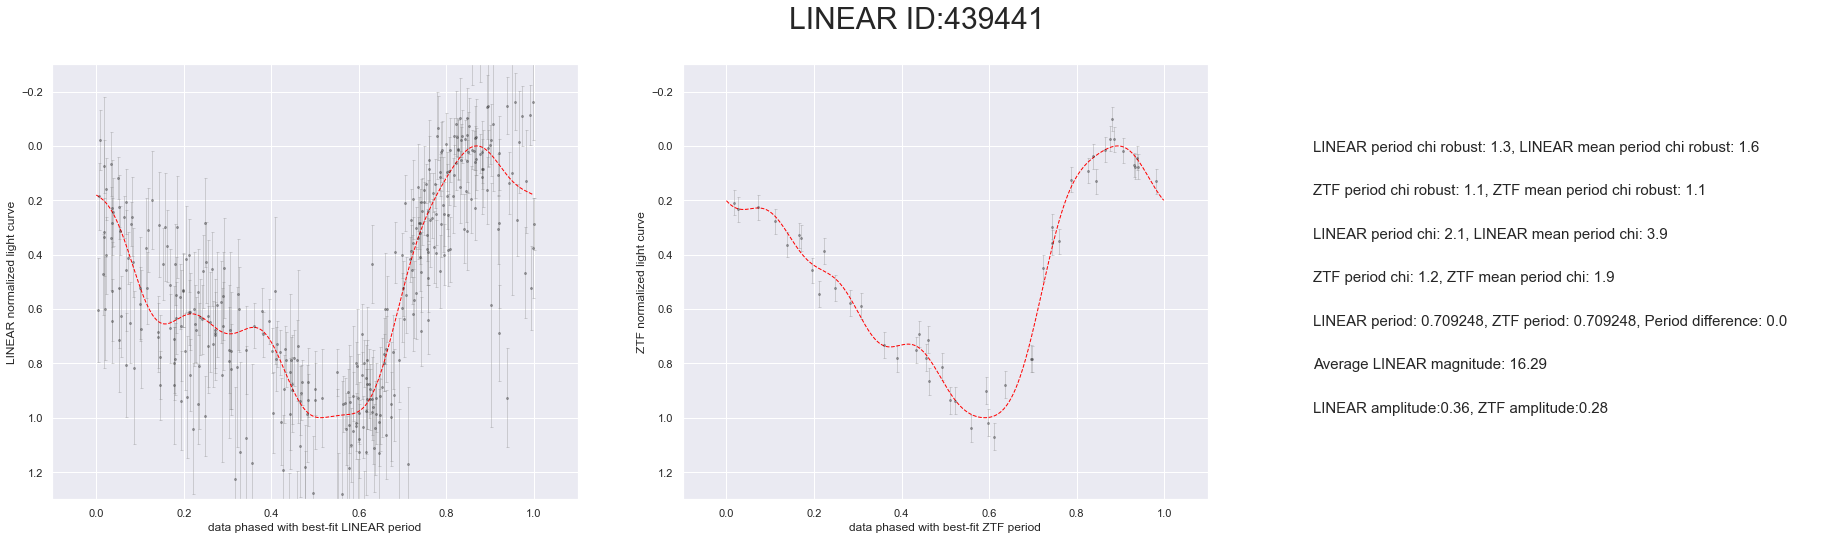

In [24]:
length = 3

BE_candidates = pd.DataFrame(())
analysis = BE_analyzer(Lids[:length], blazhko_can, BE_candidates, fits, periodogr, ztf_data, dataLINEAR)
analysis.display_interface()